[Happiness Dataset](https://www.kaggle.com/mathurinache/world-happiness-report/data?select=2020.csv)

Resources:  
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
- https://www.kaggle.com/sayar1106/extensive-eda-on-the-pursuit-of-happiness  

In [153]:
import pandas as pd
import numpy as np
import world_bank_data as wb # documentation: https://pypi.org/project/world-bank-data/
import glob
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_profiling
import plotly
import chart_studio.plotly 
import plotly.tools 
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### World happiness report

In [133]:
read_files = glob.glob("/Users/eliagandolfi/Notebooks/Happiness_analysis/dataset/*.csv")
happ_df = pd.DataFrame()
for file in read_files:
    with open(file, "r") as infile:
        year_df = pd.read_csv(infile) 
        year_df.columns = ['Country', 'Score']
        # get the year from the filename by splitting before . and after last /
        # example: '/Users/eliagandolfi/Notebooks/Happiness_analysis/dataset/2020.csv
        year = file.rsplit(".", 1)[0].rsplit("/", 1)[-1]
        year_df['Year']=year
        happ_df = happ_df.append(year_df)

happ_df.rename(columns={'Score':'happ'}, inplace=True)
happ_df

,Country,happ,Year
0,Finland,7.8087,2020
1,Denmark,7.6456,2020
2,Switzerland,7.5599,2020
3,Iceland,7.5045,2020
4,Norway,7.4880,2020
...,...,...,...
150,Rwanda,3.4710,2017
151,Syria,3.4620,2017
152,Tanzania,3.3490,2017
153,Burundi,2.9050,2017


#### World bank

In [134]:
# Define Indicators: WB API name
indicators = {'gdp_cap': 'NY.GDP.PCAP.CD', # gdp per capita
              'life_exp':'SP.DYN.LE00.IN', #life expetancy at birth
              'unempl':'SL.UEM.TOTL.ZS'} # unemployment (% of labour force)

wb_df = pd.DataFrame()

# export single series, convert dataframe, append and iterate through indicators
for i in indicators:
    ind_series = wb.get_series(indicators[i], date='2016:2020', id_or_value='value', simplify_index=True).rename(i).to_frame()
    if not wb_df.empty:
        wb_df = wb_df.join(ind_series, how='outer')
    else:
        wb_df = ind_series
        
# Check for nulls
wb_df.isna().sum()

gdp_cap      95
life_exp    320
unempl      124
dtype: int64

In [135]:
# Fill nulls with values of previous year (if null, following year)
wb_df = wb_df.fillna(method='bfill')
wb_df = wb_df.fillna(method='ffill')
wb_df.isna().sum()

gdp_cap     0
life_exp    0
unempl      0
dtype: int64

In [136]:
wb_df = wb_df.reset_index()
wb_df

,Country,Year,gdp_cap,life_exp,unempl
0,Arab World,2016,6097.239025,71.436497,10.450945
1,Arab World,2017,6102.211067,71.622526,10.641313
2,Arab World,2018,6603.351190,71.806825,10.563344
3,Arab World,2019,6580.056257,73.395956,10.336946
4,Caribbean small states,2016,9384.914524,73.395956,10.483436
...,...,...,...,...,...
1051,Zambia,2019,1291.343357,60.294000,11.425000
1052,Zimbabwe,2016,1464.583529,60.294000,5.253000
1053,Zimbabwe,2017,1548.170056,60.812000,5.168000
1054,Zimbabwe,2018,1683.740577,61.195000,5.087000


#### Press freedom (represents general freedom indexx)

In [137]:
press_df = pd.read_html('https://en.wikipedia.org/wiki/Press_Freedom_Index',flavor='bs4')[0]
press_df

,Country,2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[a][12],2010[13],2009[14],2008[15],2007[16],2006[17],2005[18],2004[19],2003[20],2002[21]
0,Norway,(001)7.84,(001)7.82,(001)7.63,(001)7.6,(003)8.79,(002)7.75,(003)6.52,(003)6.52,(001)−10.00,(001)0.00,(001)0.00,(001)1.50,(001)0.75,(006)2.00,(001)0.50,(001)0.50,(001)0.50,(001)0.50
1,Finland,(002)7.93,(002)7.90,(004)10.26,(003)8.92,(001)8.59,(001)7.52,(001)6.40,(001)6.38,(001)−10.00,(001)0.00,(001)0.00,(004)2.00,(005)1.50,(001)0.50,(001)0.50,(001)0.50,(001)0.50,(001)0.50
2,Denmark,(003)8.13,(005)9.87,(009)13.99,(004)10.36,(004)8.89,(003)8.24,(007)7.43,(006)7.08,(010)−5.67,(011)2.50,(001)0.00,(014)3.50,(008)2.00,(019)5.00,(001)0.50,(001)0.50,(005)1.00,(010)3.00
3,Sweden,(004)9.25,(003)8.31,(002)8.31,(002)8.27,(008)12.33,(005)9.47,(010)8.98,(010)9.23,(012)−5.50,(001)0.00,(001)0.00,(007)3.00,(005)1.50,(014)4.00,(012)2.00,(011)2.00,(009)1.50,(007)1.50
4,Netherlands,(005)9.96,(004)8.63,(003)10.01,(005)11.28,(002)8.76,(004)9.22,(002)6.46,(002)6.48,(003)−9.00,(001)0.00,(007)1.00,(016)4.00,(012)3.50,(001)0.50,(001)0.50,(001)0.50,(001)0.50,(001)0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Turkmenistan,(179)85.44,(180)85.44,(178)84.20,(178)84.19,(178)83.44,(178)80.83,(178)80.81,(177)79.14,(177)140.67,(176)95.33,(173)107.00,(171)95.50,(167)103.75,(167)98.50,(165)93.50,(164)99.83,(158)82.83,(136)91.50
179,North Korea,(180)85.82,(179)83.40,(180)88.87,(180)84.98,(179)83.76,(179)83.25,(179)81.96,(178)83.90,(178)141.00,(177)104.75,(174)112.50,(172)96.50,(168)108.75,(168)109.00,(167)109.00,(167)107.50,(166)99.50,(139)97.50
180,United States (extraterritorial)[g],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(057)19.00,(099)27.00,(108)30.00,(119)31.00,(111)36.00,(119)31.50,(137)48.50,(108)36.00,(135)41.00,NaN
181,Israel (extraterritorial)[h],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(133)59.00,(132)47.00,(150)55.50,(149)51.50,(103)32.00,(135)47.00,NaN,(115)37.50,(146)49.00,NaN


In [138]:
# Turn columns into rows to match previous dataframe schema
press_df = press_df.melt(id_vars=["Country"], 
        var_name="Year", 
        value_name="press_free")
press_df

,Country,Year,press_free
0,Norway,2020[4],(001)7.84
1,Finland,2020[4],(002)7.93
2,Denmark,2020[4],(003)8.13
3,Sweden,2020[4],(004)9.25
4,Netherlands,2020[4],(005)9.96
...,...,...,...
3289,Turkmenistan,2002[21],(136)91.50
3290,North Korea,2002[21],(139)97.50
3291,United States (extraterritorial)[g],2002[21],NaN
3292,Israel (extraterritorial)[h],2002[21],NaN


In [139]:
# fillna
press_df = press_df.fillna(method='bfill')
press_df = press_df.fillna(method='ffill')
# Clean up column values (keep only year and value)
press_df['Year'] = press_df['Year'].str.split('[').str[0]
press_df['press_free'] = press_df['press_free'].str.split(')').str[-1]
press_df

,Country,Year,press_free
0,Norway,2020,7.84
1,Finland,2020,7.93
2,Denmark,2020,8.13
3,Sweden,2020,9.25
4,Netherlands,2020,9.96
...,...,...,...
3289,Turkmenistan,2002,91.50
3290,North Korea,2002,97.50
3291,United States (extraterritorial)[g],2002,97.50
3292,Israel (extraterritorial)[h],2002,97.50


In [140]:
# merge three dataframes
df = pd.merge(pd.merge(happ_df, wb_df, on=['Year', 'Country'], how='left'), press_df, on=['Year', 'Country'], how='left').set_index('Year')

In [141]:
#Finally fill the Nan for the missing years
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')
df.isna().sum()
# convert press free to numeric (it's still string)
df.press_free = pd.to_numeric(df.press_free, errors='coerce')
df.dtypes

Country        object
happ          float64
gdp_cap       float64
life_exp      float64
unempl        float64
press_free    float64
dtype: object

#### Exploratory analysis

In [142]:
# describe the happiness index
df['happ'].describe()

count    935.000000
mean       5.394436
std        1.124935
min        2.566900
25%        4.540000
50%        5.353500
75%        6.198500
max        7.808700
Name: happ, dtype: float64

<AxesSubplot:xlabel='happ'>

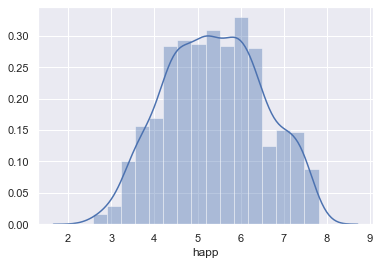

In [143]:
# distribution plot for happiness index
sns.distplot(df['happ'])

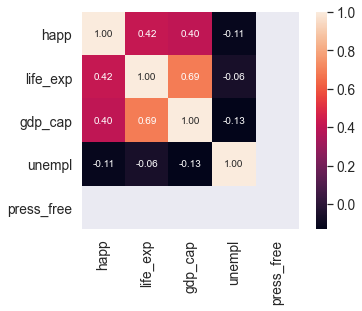

In [144]:
# look at correlation
k = 6 #number of variables for heatmap
cols = df.corr().nlargest(k, 'happ')['happ'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

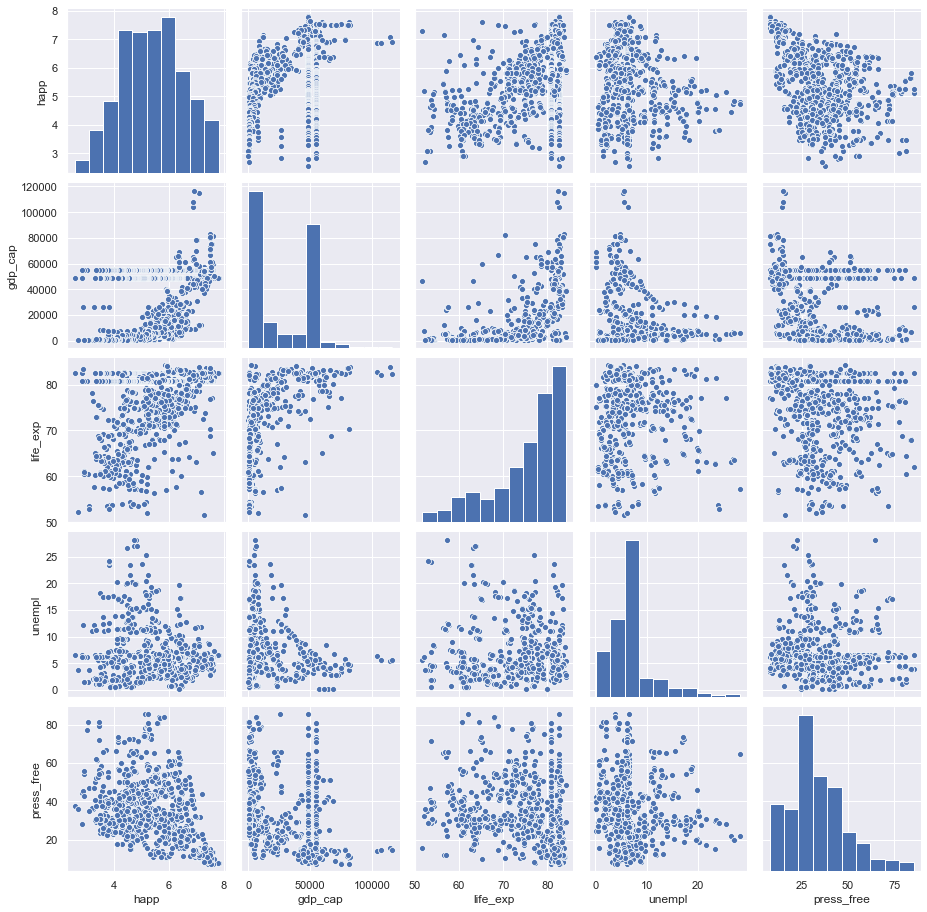

In [145]:
#scatterplot
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

In [146]:
# Analyze profiling
#pfr = pandas_profiling.ProfileReport(df)
#pfr.to_notebook_iframe() 

<AxesSubplot:xlabel='Year'>

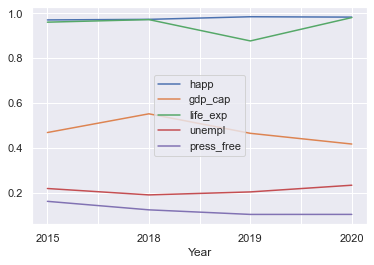

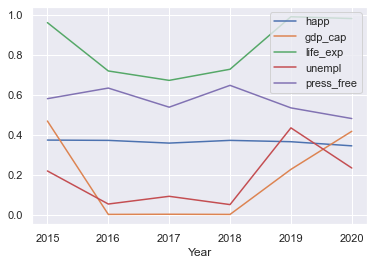

In [147]:
# convert columns % of max
norm_df = df
for col in df.columns:
    # keep only numerical
    if col in norm_df.select_dtypes(exclude=['object']):
        norm_df[col]=df[col]/df[col].max()

top10 = norm_df.nlargest(10,"happ")
top10 = top10.groupby('Year').mean()
bottom10 = norm_df.nsmallest(10,"happ")
bottom10 = bottom10.groupby('Year').mean()

top10.plot()
bottom10.plot()

#### Predicting happiness with linear regression

In [151]:
X = df[['gdp_cap', 'life_exp', 'unempl', 'press_free']].values
y = df['happ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
df['press_free'] = df['press_free'].fillna(method='bfill')
df['press_free'] = df['press_free'].fillna(method='ffill')
df.isna().sum()

Country       0
happ          0
gdp_cap       0
life_exp      0
unempl        0
press_free    0
dtype: int64

In [154]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)
y_fitted = model.predict(X_train)
y_preds = model.predict(X_test)
print("Mean squared error for the training data is: {:.4f}".format(mean_squared_error(y_fitted, y_train)))
print("Mean squared error for the test data is: {:.4f}".format(mean_squared_error(y_preds, y_test)))

Mean squared error for the training data is: 0.0135
Mean squared error for the test data is: 0.0152
